# Q2.

In [14]:
import cv2
import argparse
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity


def convolve(image, kernel):
  (iH, iW) = image.shape[:2]
  (kH, kW) = kernel.shape[:2]
  pad = (kW - 1) // 2
  image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
  output = np.zeros((iH, iW), dtype="float32")
  for y in np.arange(pad, iH + pad):
    for x in np.arange(pad, iW + pad):
      roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
      k = (roi * kernel).sum()
      output[y - pad, x - pad] = k
  output = rescale_intensity(output, in_range=(0, 255))
  output = (output * 255).astype("uint8")
  return output

In [15]:
input_image = cv2.imread("img1.jpg", flags=cv2.IMREAD_GRAYSCALE)
print(input_image)
print(input_image.shape)

[[159 159 159 ... 153 153 152]
 [155 157 158 ... 152 151 150]
 [156 156 157 ... 152 151 150]
 ...
 [120 121 128 ... 125 116 106]
 [122 119 124 ... 129 117 104]
 [126 122 127 ... 112 110 119]]
(512, 512)


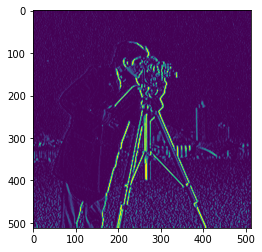

In [16]:
filter1 = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

output_1 = convolve(input_image, filter1)
plt.imshow(output_1)
plt.show()

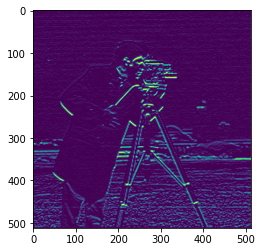

In [17]:
filter2 = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

output_2 = convolve(input_image, filter2)
plt.imshow(output_2)
plt.show()

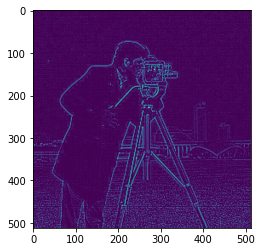

In [18]:
filter3 = np.array((
	[-1, -1, -1],
	[-1, 8, -1],
	[-1, -1, -1]), dtype="int")

output_3 = convolve(input_image, filter3)
plt.imshow(output_3)
plt.show()

(512, 512)


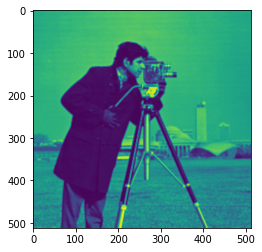

In [19]:
filter4 = np.array((
	[1/9, 1/9, 1/9],
	[1/9, 1/9, 1/9],
	[1/9, 1/9, 1/9]), dtype="double")

output_4 = convolve(input_image, filter4)
print(output_4.shape)
plt.imshow(output_4)
plt.show()

# ًQ3.

In [21]:
! pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [40]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch, Hyperband

In [41]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

x_train = normalize(x_train)
x_test = normalize(x_test)
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
def build_model(hp):
  model = keras.Sequential()
  model.add(layers.Conv2D(hp.Int('input_units', min_value=32, max_value=256,
                                 step=32),
                           (3, 3), input_shape=x_train.shape[1:]))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  for i in range(hp.Int('num_of_conv_layers', 1, 4)):
      model.add(layers.Conv2D(hp.Int(f'conv_{i}_units', min_value=32,
                                     max_value=256, step=32), (3, 3)))
      model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Flatten())
  for i in range(hp.Int('num_of_dense_layers', 1, 4)):
      model.add(layers.Dense(hp.Int(f'num_of_nodes', min_value=32,
                                    max_value=256, step=32)))
      model.add(layers.Activation('relu'))
  model.add(layers.Dense(10))
  model.add(layers.Activation("softmax"))
  optimizer = hp.Choice('optimizer', values=['adam', 'RMSprop', 'SGD'])
  lr = hp.Float('lr', min_value=0.001, max_value=0.01, step=0.001)

  if(optimizer=='adam'):
    model.compile(
      loss="categorical_crossentropy",
      optimizer=optimizers.Adam(learning_rate=lr),
      metrics=['accuracy']
    ) 
  elif(optimizer=='SGD'):
    model.compile(
      loss="categorical_crossentropy",
      optimizer=optimizers.SGD(learning_rate=lr, nesterov=True,
                               momentum=0.95,), metrics=['accuracy']
    ) 
  else:
    model.compile(
      loss="categorical_crossentropy",
      optimizer=optimizers.RMSprop(learning_rate=lr),
      metrics=['accuracy']
    ) 
  
     
  return model

In [56]:
number_of_epochs = 20

tuner = Hyperband(
  build_model,
  objective='val_accuracy',
  max_epochs=6,
  executions_per_trial=4,
)



tuner.search(x_train, y_train, epochs=number_of_epochs, validation_split=0.3)


print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())

best_model.save('Q3.h5')

print(tuner.get_best_hyperparameters()[0].values)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 activation (Activation)     (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       147584    
                                                                 
 activation_1 (Activation)   (None, 13, 13, 128)       0      

In [57]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

313/313 [==============================] - 3s 7ms/step - loss: 1.0422 - accuracy: 0.6523
loss: 1.0422279834747314
accuracy: 0.6523000001907349
